In [54]:
#project inspired by work done by David Yoo (https://www.linkedin.com/in/davidsyoo/)

#essential packages
import os
import numpy as np
import pandas as pd
import dataframe_image as dfi
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

#visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#tools & metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
import shap

#statistical & ML tools
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#pandas show all columns
pd.set_option('display.max_columns', None)

#%load_ext autoreload
#%autoreload 2
#%run ./__init__

In [55]:
#Historical MVP data
data_path = os.path.dirname(os.getcwd()) + '\\NBA MVP' + '\\data' + '\\master_table.csv'
master_table = pd.read_csv(data_path)
master_table.head() # first 5 rows

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,year,team,W,W/L%,seed,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,assist_percentage,steal_percentage,block_percentage,turnover_percentage,usage_percentage,offensive_win_shares,defensive_win_shares,win_shares,win_shares_per_48_minutes,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player
0,1,Kareem Abdul-Jabbar,32,LAL,147.0,147.0,221,0.665,82,38.3,24.8,10.8,4.5,1.0,3.4,0.604,0.000,0.765,14.8,0.227,1980,Los Angeles Lakers,60.0,0.732,1.0,25.3,0.639,0.001,0.344,7.2,22.2,15.4,16.5,1.2,4.6,15.7,24.1,9.5,5.3,14.8,0.227,4.8,2.4,7.2,7.3
1,2,Julius Erving,29,PHI,31.5,31.5,221,0.143,78,36.1,26.9,7.4,4.6,2.2,1.8,0.519,0.200,0.787,12.5,0.213,1980,Philadelphia 76ers,59.0,0.720,2.0,25.4,0.568,0.012,0.331,8.6,12.9,10.9,21.4,2.8,2.7,13.3,30.3,7.3,5.2,12.5,0.213,5.7,1.9,7.6,6.8
2,3,George Gervin,27,SAS,19.0,19.0,221,0.086,78,37.6,33.1,5.2,2.6,1.4,1.0,0.528,0.314,0.852,10.6,0.173,1980,San Antonio Spurs,41.0,0.500,4.5,24.0,0.587,0.053,0.306,5.7,8.9,7.3,11.0,1.6,1.4,10.3,31.7,9.3,1.3,10.6,0.173,5.5,-1.6,3.9,4.4
3,4,Larry Bird,23,BOS,15.0,15.0,221,0.068,82,36.0,21.3,10.4,4.5,1.7,0.6,0.474,0.406,0.836,11.2,0.182,1980,Boston Celtics,61.0,0.744,1.0,20.5,0.538,0.098,0.246,8.3,23.6,16.0,18.5,2.3,1.0,14.0,25.3,5.6,5.6,11.2,0.182,3.0,1.5,4.5,4.8
4,5T,Tiny Archibald,31,BOS,2.0,2.0,221,0.009,80,35.8,14.1,2.5,8.4,1.3,0.1,0.482,0.222,0.830,8.9,0.148,1980,Boston Celtics,61.0,0.744,1.0,15.3,0.574,0.023,0.548,2.3,5.3,3.8,30.2,1.7,0.2,19.7,17.0,5.9,2.9,8.9,0.148,1.4,-0.3,1.1,2.3


# Exploratory Data Analysis

In [56]:
master_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Rank                           679 non-null    object 
 1   Player                         679 non-null    object 
 2   Age                            679 non-null    int64  
 3   Tm                             679 non-null    object 
 4   First                          679 non-null    float64
 5   Pts Won                        679 non-null    float64
 6   Pts Max                        679 non-null    int64  
 7   Share                          679 non-null    float64
 8   G                              679 non-null    int64  
 9   MP                             679 non-null    float64
 10  PTS                            679 non-null    float64
 11  TRB                            679 non-null    float64
 12  AST                            679 non-null    flo

### Correlation 

### Mutual Information

In [57]:
def calculate_ml_scores(df):
    x = df.copy()
    y = x["Share"]

    x.drop('Share', axis=1, inplace=True)

    # Label encoding for categoricals
    for colname in x.select_dtypes("object"):
        x[colname], _ = x[colname].factorize()

    # All discrete features should now have integer dtypes (double-check this before using MI!)
    discrete_features = x.dtypes == int
    mi_scores = mutual_info_regression(x, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=x.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return x, y, mi_scores

In [58]:
#dropping columns
to_drop_mi = ['Rank','Player','Age','year','Tm','team','First','Pts Won','Pts Max','WS','WS/48']
master_table_mi = master_table.copy()
master_table_mi.drop(to_drop_mi, axis=1, inplace=True)

In [59]:
X, y, mi_scores = calculate_ml_scores(df=master_table_mi)

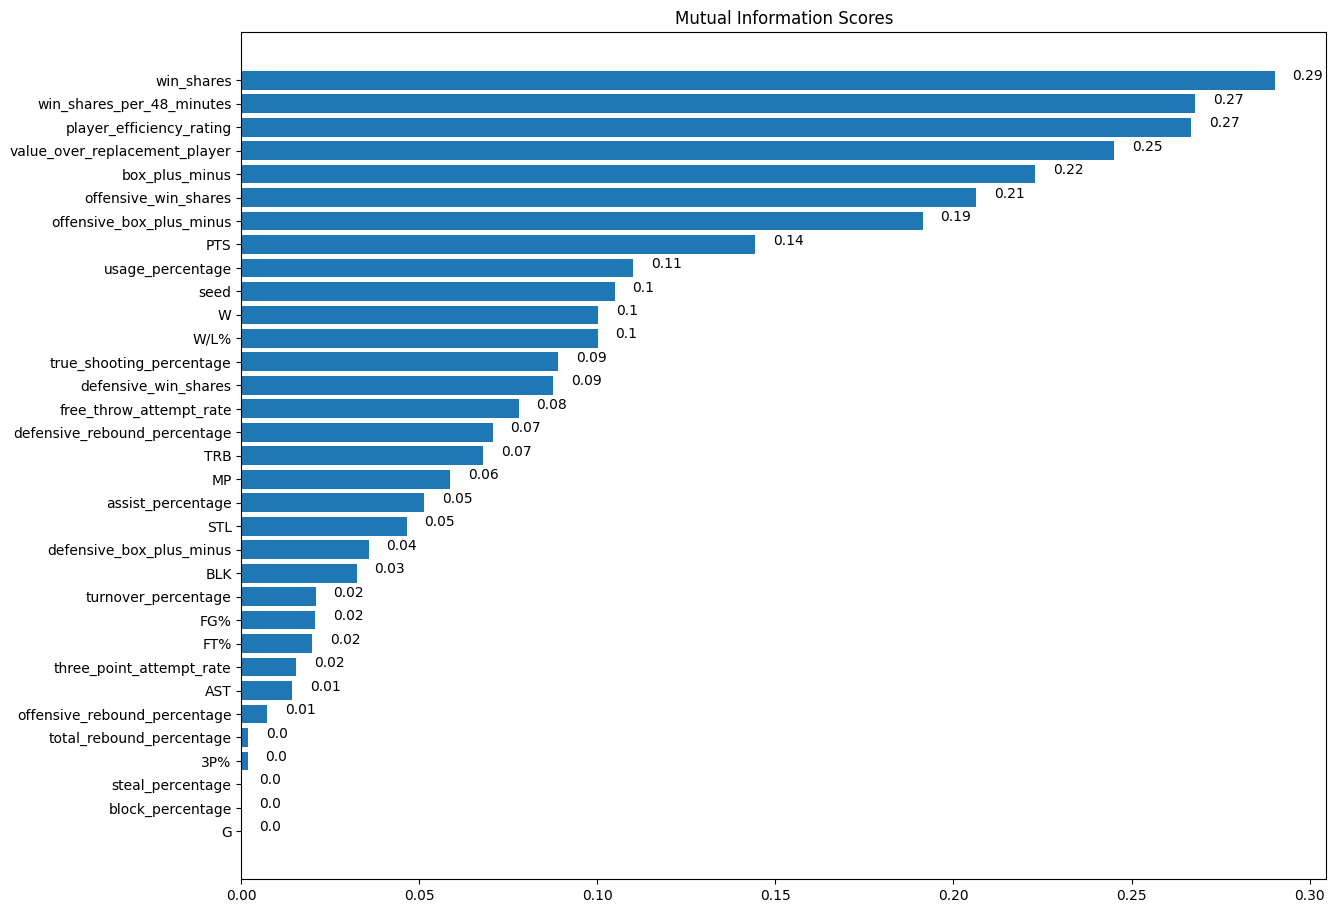

In [60]:
def plot_mi_scores(scores, figsize):
    scores = scores.sort_values(ascending=True)
    ticks = list(scores.index)
    width = np.arange(len(scores))
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(width, scores)
    
    for index, value in enumerate(scores):
        plt.text(value +0.005 , index, str(round(value,2)))
    
    plt.yticks(width, ticks)    
    plt.title("Mutual Information Scores")

plot_mi_scores(mi_scores, figsize=(14,11))

In [61]:
def add_win_lose_col(df):
    rank_lst = []
    for i in list(df['Rank']):
        if i == '1':
            rank_lst.append('won')
        else:
            rank_lst.append('lost')
    master_table_rank = df.copy()
    master_table_rank['Win/Lose'] = rank_lst
    return master_table_rank

In [62]:
def show_feature_vs_share(feature, df):
    fig = px.scatter(data_frame = df,
               x=feature,
               y='Share',
               color='Win/Lose',
               color_discrete_sequence=['blue','gray'], 
               hover_data={
                   'Win/Lose': False,
                   'Player': True, 
                   'year': True,
                   'seed': True,
                   'W/L%': True, 
                   'W': True
                   
               })
    fig.update_layout(height=500,
                     title = f"{feature} vs. MVP share")
    fig.show()

In [63]:
# Important features 
features = ['win_shares', 
            'player_efficiency_rating',
            'value_over_replacement_player',
            'box_plus_minus',
            'offensive_box_plus_minus',
            'usage_percentage',
            'seed',
            'W',
            'W/L%',
            'PTS']

master_table_rank = add_win_lose_col(df=master_table)

for feature in features:
    show_feature_vs_share(feature=feature, df=master_table_rank)

#### We detect slightly linear relationships

# Data Preprocessing 

In [64]:
#drop unnecessary columns 

to_drop = [
    'Rank',
    'Player',
    'Age',
    'year',
    'Tm',
    'team',
    'First',
    'Pts Won',
    'Pts Max',
    'WS/48',
    'WS',
    'MP',
    'G',
    'W', 
    'FG%',
    '3P%',
    'STL', 
    'BLK',
    'three_point_attempt_rate',
    'total_rebound_percentage',
    'offensive_rebound_percentage',
    'block_percentage',
    'defensive_rebound_percentage',
    'steal_percentage',
    'turnover_percentage',
    'assist_percentage',
    'AST',
    'TRB',
    'FT%',
    'win_shares', 
    #'value_over_replacement_player', 
    'box_plus_minus', 
    #'offensive_box_plus_minus', 
    'defensive_box_plus_minus',
    'offensive_win_shares', 
    'defensive_win_shares', 
    'true_shooting_percentage' 
]

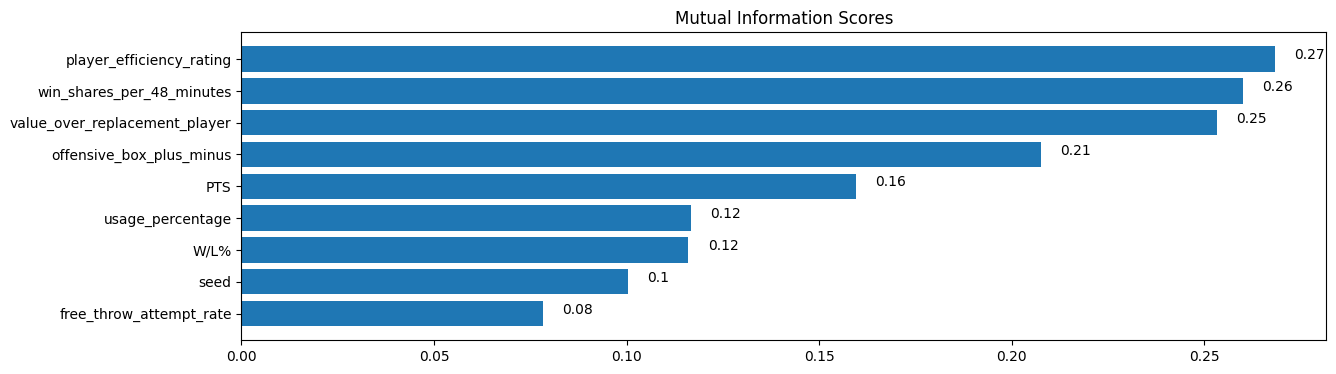

In [65]:
#new Mutual Information Score analysis
master_table_mi2 = master_table.copy()
master_table_mi2.drop(to_drop, axis=1, inplace=True)
X, y, mi_scores2 = calculate_ml_scores(df=master_table_mi2)
plot_mi_scores(mi_scores2, figsize=(14,4))

## Testing & Training Data

testing on selected year and training on other years 

In [66]:
def train_test_split_by_year(year, df, scaling=False):
    #test year = selected year, train year = other years outside of selected year
    
    train_df = df[df['year'] != year]
    test_df = df[df['year'] == year]
    
    train_df2 = train_df.copy()
    test_df2 = test_df.copy()
    
    train_df2.drop(to_drop, axis=1, inplace=True)
    test_df2.drop(to_drop, axis=1, inplace=True)
    
    if scaling == True:
        sc_X = StandardScaler()
        sc_y = StandardScaler()
        train_df2 = sc_X.fit_transform(train_df2)
        test_df2 = sc_y.fit_transform(test_df2)
    
    X_train = train_df2.copy()
    y_train = X_train["Share"]
    
    X_test = test_df2.copy()
    y_test = X_test["Share"]

    X_train.drop('Share', axis=1, inplace=True)
    cols = X_train.columns
    X_test.drop('Share', axis=1, inplace=True)

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test, cols

## Helper Functions

In [67]:
def run_model(regressor, X_train, y_train, X_test, y_test, df, year):
    model = regressor
    model.fit(X_train, y_train) 
    predictions = model.predict(X_test)
    mae = mean_absolute_error(predictions, y_test)
    r2 = r2_score(y_test, predictions)
    
    mvp_race = df[df['year'] == year]
    mvp_race['predicted_share'] = predictions
    mvp_race = mvp_race.sort_values(["Share", "predicted_share"], ascending = (False, False))
                                    
    actual_winner = mvp_race[mvp_race['Share'] == mvp_race['Share'].max()]['Player']
    predicted_winner = mvp_race[mvp_race['predicted_share'] == mvp_race['predicted_share'].max()]['Player']
    return model, mae, r2, predicted_winner.iloc[0], actual_winner.iloc[0], mvp_race

average statistics and accuracy

In [68]:
years = [year for year in range(1980, 2022)]

def run_model_average(df, regressor, scaling=False, print_metrics=False):
    mae_lst = []
    r2_lst = []
    predicted_lst = []
    actual_lst = []
    label_lst =[]
    model_lst = []
    for year in tqdm(years):
        X_train, y_train, X_test, y_test, cols = train_test_split_by_year(year=year, df=df, scaling=False)
        model, mae, r2, predicted_winner, actual_winner, mvp_race =  run_model(regressor, X_train, y_train, X_test, y_test, df, year)
        
        if predicted_winner == actual_winner:
            label = 'correct'
        else:
            label = 'incorrect'
        mae_lst.append(mae)
        r2_lst.append(r2)
        predicted_lst.append(predicted_winner)
        actual_lst.append(actual_winner)
        label_lst.append(label)
        model_lst.append(model)
    d = {
    'year': years,
    'MAE': mae_lst,
    'R squared': r2_lst,
    'Predicted MVP': predicted_lst,
    'Actual MVP': actual_lst,
    'Label': label_lst
    }

    summary = pd.DataFrame(d)
    correct_count = summary['Label'].value_counts().iloc[0]
    incorrect_count = summary['Label'].value_counts().iloc[1]
    accuracy = correct_count / (correct_count + incorrect_count)
    avg_mae = summary['MAE'].mean()
    avg_r2  = summary['R squared'].mean()
    
    if print_metrics == True:
        print(f"Average MAE: {avg_mae}")
        print(f"Average R squared: {avg_r2}")
        print(f"Prediction accuracy: {accuracy}")
    return avg_mae, avg_r2, accuracy, summary, model_lst, cols        

### Models:
- Linear Regression
- XGBoost Regressor
- LightGBM Regressor


#### Linear Model

In [69]:
lr_avg_mae, lr_avg_r2, lr_accuracy, lr_summary, lr_models, cols = run_model_average(df=master_table,
                  regressor = LinearRegression(),
                 scaling=True,
                print_metrics=True)

100%|██████████| 42/42 [00:00<00:00, 195.32it/s]

Average MAE: 0.14528095583827477
Average R squared: 0.47169459188854956
Prediction accuracy: 0.6428571428571429


#### XGBoost Model

In [70]:
xgb_avg_mae, xgb_avg_r2, xgb_accuracy, xgb_summary, xgb_models, xgb_cols = run_model_average(df=master_table,
                  regressor = XGBRegressor(n_estimators=16, max_depth=5, learning_rate = 0.2745, subsample=1, colsample_bytree=1),
                 scaling=False, print_metrics=True)

100%|██████████| 42/42 [00:00<00:00, 44.31it/s]

Average MAE: 0.10327332429727709
Average R squared: 0.6062658034118551
Prediction accuracy: 0.8333333333333334


In [71]:
xgb_summary

,year,MAE,R squared,Predicted MVP,Actual MVP,Label
0,1980,0.068104,0.711039,Kareem Abdul-Jabbar,Kareem Abdul-Jabbar,correct
1,1981,0.044850,0.605227,Julius Erving,Julius Erving,correct
2,1982,0.079323,0.264734,Magic Johnson,Moses Malone,incorrect
3,1983,0.078697,0.458365,Moses Malone,Moses Malone,correct
4,1984,0.089311,0.552824,Larry Bird,Larry Bird,correct
5,1985,0.043589,0.896859,Larry Bird,Larry Bird,correct
6,1986,0.092436,0.706484,Larry Bird,Larry Bird,correct
7,1987,0.071820,0.709262,Magic Johnson,Magic Johnson,correct
8,1988,0.092211,0.652065,Michael Jordan,Michael Jordan,correct
9,1989,0.064810,0.822390,Magic Johnson,Magic Johnson,correct


In [72]:
def avg_feature_importance(models, cols):
    lst = []
    for model in models:
        feature_importance = list(model.feature_importances_)
        lst.append(feature_importance)
        
    df = pd.DataFrame(lst, columns=cols)
    mean_features = df.mean()
    
    #df2 = pd.DataFrame([cols ,mean_features], columns=['Feature', 'Feature Importance'])
    df2 = pd.DataFrame([cols ,mean_features]).T
    df2 = df2.rename(columns={0:'Feature', 1:'Score'}).sort_values(by='Score', ascending=False)
    
    #plt.rcParams["figure.figsize"] = (7,4)
    plt.title('Feature Importance Score')
    sns.barplot(x='Score',
                y= 'Feature',
               data=df2,
                  )
    plt.show()

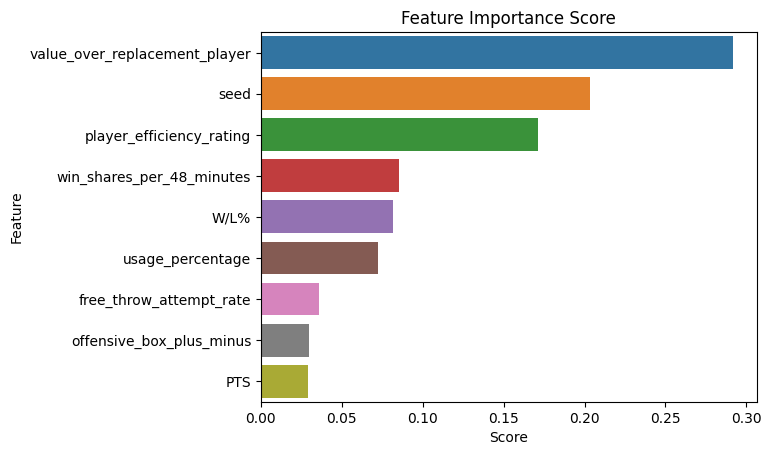

In [73]:
avg_feature_importance(models=xgb_models, cols=xgb_cols)

#### LightGBM

In [74]:
lgbm_avg_mae, lgbm_avg_r2, lgbm_accuracy, lgbm_summary, lgbm_models, lgbm_cols = run_model_average(df=master_table,
                  regressor = LGBMRegressor(n_estimators=23,
                                            max_depth=4,
                                            learning_rate=0.15,
                                            num_leaves=28,
                                            boosting_type='goss',
                                            random_state = 0,
                                           ),
                 scaling=False, print_metrics=True)

100%|██████████| 42/42 [00:00<00:00, 67.53it/s]

Average MAE: 0.10605503800455612
Average R squared: 0.6119918538779788
Prediction accuracy: 0.7619047619047619


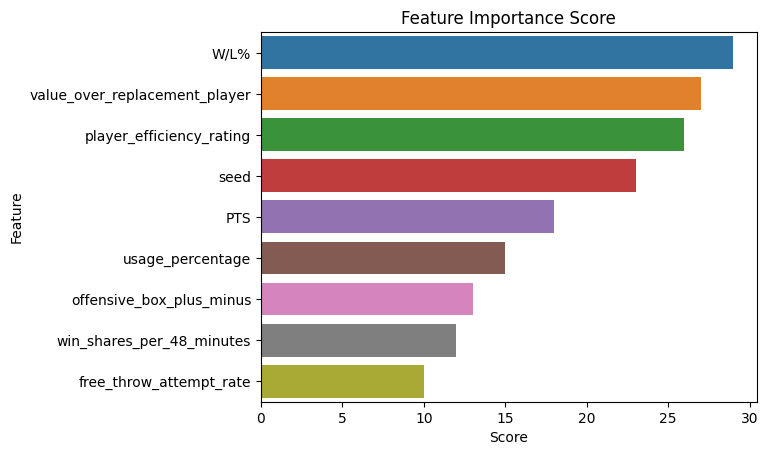

In [75]:
avg_feature_importance(models=lgbm_models, cols=lgbm_cols)


### Comparision of Models

In [76]:
d = {
    'Model': ['Linear Regression','XGBoost Regressor', 'LGBM Regressor'],
    'average MAE': [lr_avg_mae, xgb_avg_mae, lgbm_avg_mae],
    'average R squared': [lr_avg_r2, xgb_avg_r2, lgbm_avg_r2],
    'accuracy': [lr_accuracy, xgb_accuracy, lgbm_accuracy],
}
model_summary_df = pd.DataFrame(d)
model_summary_df.style.highlight_max(subset = ['average R squared', 'accuracy'],
                       color = 'lightgreen', axis = 0)


,Model,average MAE,average R squared,accuracy
0,Linear Regression,0.145281,0.471695,0.642857
1,XGBoost Regressor,0.103273,0.606266,0.833333
2,LGBM Regressor,0.106055,0.611992,0.761905


In [77]:
#all models in models list have same parameters
best_xgb_model = xgb_models[0]
best_lgbm_model = lgbm_models[0]

In [78]:
def validate_year(year):
    X_train, y_train, X_test, y_test, cols = train_test_split_by_year(year, df=master_table, scaling=False)
    model, mae, r2, predicted_winner, actual_winner, mvp_race = run_model(best_xgb_model,
                                              X_train, y_train, X_test, y_test, df=master_table, year=year)
    # shift column 'Name' to first position
    nineth_column = mvp_race.pop('predicted_share')
    # first_column) function
    mvp_race.insert(8, 'predicted_share', nineth_column)
    mvp_race = mvp_race.reset_index(drop=True)

    X_test_df = pd.DataFrame(columns=cols, data = X_test)
    
    print(f'Predicted: {predicted_winner}')
    print(f'Actual: {actual_winner}')
    avg_feature_importance(models=[model], cols=cols)
    
    return model, X_test_df, mvp_race #mvp_race.style.highlight_max(subset = ['Share', 'predicted_share'], color = 'lightgreen', axis = 0)

In [79]:
def visualize_shap_values(mvp_race, model):
    top_candidates = list(mvp_race.head(3)['Player'])

    for idx, player in enumerate(top_candidates):
        data_for_prediction = mvp_race[mvp_race['Player'] == player]
        data_for_prediction = data_for_prediction[list(xgb_cols)]
        data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
        rank = idx + 1
        print(f"Rank: {rank}: {player}")

        # Create object that can calculate shap values
        explainer = shap.TreeExplainer(model)
        # Calculate Shap values
        shap_values = explainer.shap_values(data_for_prediction_array)
        shap.initjs()
        display(shap.force_plot(explainer.expected_value, shap_values, data_for_prediction))

Predicted: Derrick Rose
Actual: Derrick Rose


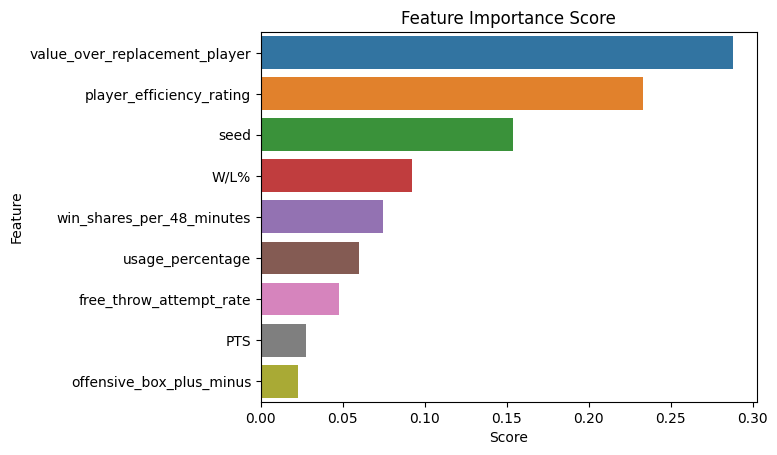

Rank: 1: Derrick Rose


Rank: 2: Dwight Howard


Rank: 3: LeBron James


In [80]:
model, X_test_df, mvp_race = validate_year(year=2011)
visualize_shap_values(mvp_race, model)

# Predicting 2022 NBA MVP

In [81]:
# 2022 nba stats
data_path_2022 = os.path.dirname(os.getcwd()) +  '\\NBA MVP' + '\\data' + '\\data_2022.csv'
data_2022 = pd.read_csv(data_path_2022)
data_2022_cleaned = data_2022.copy()
data_2022_cleaned = data_2022_cleaned[list(xgb_cols)]
data_2022_cleaned

,PTS,W/L%,seed,player_efficiency_rating,free_throw_attempt_rate,usage_percentage,win_shares_per_48_minutes,offensive_box_plus_minus,value_over_replacement_player
0,29.880597,0.622,3,32.1,0.615,34.9,0.281,7.6,7.4
1,30.573529,0.622,4,31.2,0.602,37.2,0.252,7.2,6.5
2,27.081081,0.585,6,32.8,0.357,31.9,0.296,9.2,9.8


In [82]:
data_2022

,Player,games_played,team,PTS,AST,STL,BLK,FG%,3P%,TRB,Tm,W,W/L%,seed,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,assist_percentage,steal_percentage,block_percentage,turnover_percentage,usage_percentage,offensive_win_shares,defensive_win_shares,win_shares,win_shares_per_48_minutes,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player
0,Giannis Antetokounmpo,67,milwaukee bucks,29.880597,5.791045,1.074627,1.358209,0.553414,0.293388,11.611940,MIL,51,0.622,3,32.1,0.633,0.194,0.615,6.6,30.4,18.7,31.7,1.6,4.0,12.2,34.9,9.2,3.7,12.9,0.281,7.6,3.5,11.2,7.4
1,Joel Embiid,68,philadelphia 76ers,30.573529,4.176471,1.132353,1.455882,0.499250,0.370518,11.705882,PHI,51,0.622,4,31.2,0.616,0.188,0.602,7.2,31.1,19.4,23.5,1.7,3.9,11.3,37.2,7.9,4.1,12.0,0.252,7.2,2.0,9.2,6.5
2,Nikola Jokic,74,denver nuggets,27.081081,7.891892,1.472973,0.851351,0.582761,0.336806,13.770270,DEN,48,0.585,6,32.8,0.661,0.220,0.357,9.6,35.5,23.0,42.6,2.2,2.3,15.6,31.9,10.8,4.5,15.2,0.296,9.2,4.5,13.7,9.8


In [83]:
def prep_train_test(df):
    #train; using hitorical data from 1980 - 2021
    forecast_X_train_df = df.copy()
    forecast_X_train_df.drop(to_drop, axis=1, inplace=True)
    forecast_y_train_df = forecast_X_train_df['Share']
    forecast_X_train_df.drop(['Share'], axis=1, inplace=True)
    
    #data to be forecasted: 2022 mvp candidates from NBA's MVP ladder
    forecast_X_test_df = data_2022_cleaned
    
    print(f'Training dataset columns: \n{list(forecast_X_train_df.columns)} \n')
    print(f'Forecasting dataset columns: \n{list(forecast_X_test_df.columns)}')
    return forecast_X_train_df, forecast_y_train_df, forecast_X_test_df

In [84]:
def fit_forecast_model(regressor):
    model = regressor
    model.fit(forecast_X_train_df, forecast_y_train_df) 
    predictions = model.predict(forecast_X_test_df)
    
    mvp_race_forecast = data_2022.copy()
    mvp_race_forecast['Share Prediction'] = predictions
    mvp_race_forecast = mvp_race_forecast.sort_values(["Share Prediction"], ascending = (False))
    
    mvp_race_forecast_sub = mvp_race_forecast[[
                                                'Player',
                                                'Share Prediction',
                                                'PTS',
                                               'value_over_replacement_player',
                                               'seed',
                                                'W/L%',
                                               'player_efficiency_rating',
                                               'win_shares_per_48_minutes',
                                                'offensive_box_plus_minus',
                                                'usage_percentage',
                                            'free_throw_attempt_rate'
                                              ]].reset_index(drop=True)
    mvp_race_forecast_sub.head()
    avg_feature_importance(models=[model], cols=data_2022_cleaned.columns)
    return model, mvp_race_forecast_sub

In [85]:
def show_highlighted_df(df):
    return df.style.highlight_max(subset = ['value_over_replacement_player',
                                                    'player_efficiency_rating',
                                                    'W/L%',
                                                    'win_shares_per_48_minutes',
                                                    'usage_percentage',
                                                    'free_throw_attempt_rate',
                                                    'offensive_box_plus_minus',
                                                    'PTS',
                                                    'Share Prediction'], color = 'lightgreen', axis = 0)

In [86]:
forecast_X_train_df, forecast_y_train_df, forecast_X_test_df = prep_train_test(df=master_table)

Training dataset columns: 
['PTS', 'W/L%', 'seed', 'player_efficiency_rating', 'free_throw_attempt_rate', 'usage_percentage', 'win_shares_per_48_minutes', 'offensive_box_plus_minus', 'value_over_replacement_player'] 

Forecasting dataset columns: 
['PTS', 'W/L%', 'seed', 'player_efficiency_rating', 'free_throw_attempt_rate', 'usage_percentage', 'win_shares_per_48_minutes', 'offensive_box_plus_minus', 'value_over_replacement_player']


# XGBoost Model

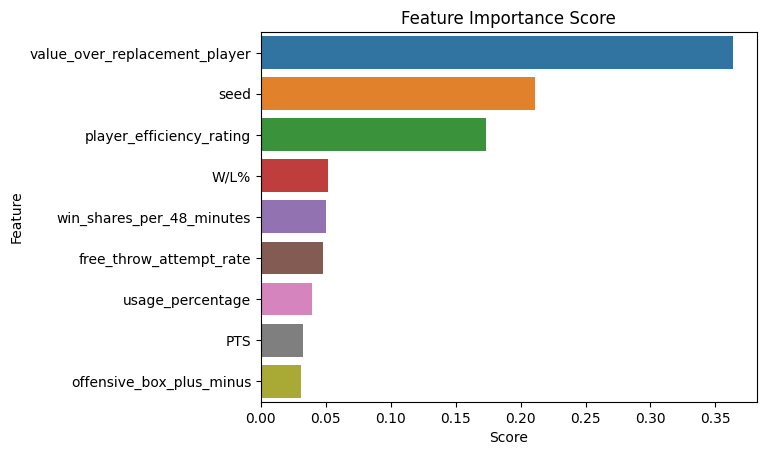

In [87]:
#best xgb model
xgb_model, xgb_mvp_race_forecast = fit_forecast_model(regressor = XGBRegressor(
                                            n_estimators=16,
                                            max_depth=5,
                                            learning_rate=0.2745))

In [88]:
show_highlighted_df(df=xgb_mvp_race_forecast)

,Player,Share Prediction,PTS,value_over_replacement_player,seed,W/L%,player_efficiency_rating,win_shares_per_48_minutes,offensive_box_plus_minus,usage_percentage,free_throw_attempt_rate
0,Nikola Jokic,0.679943,27.081081,9.800000,6,0.585000,32.800000,0.296000,9.200000,31.900000,0.357000
1,Giannis Antetokounmpo,0.565778,29.880597,7.400000,3,0.622000,32.100000,0.281000,7.600000,34.900000,0.615000
2,Joel Embiid,0.425511,30.573529,6.500000,4,0.622000,31.200000,0.252000,7.200000,37.200000,0.602000


# LightGBM Model

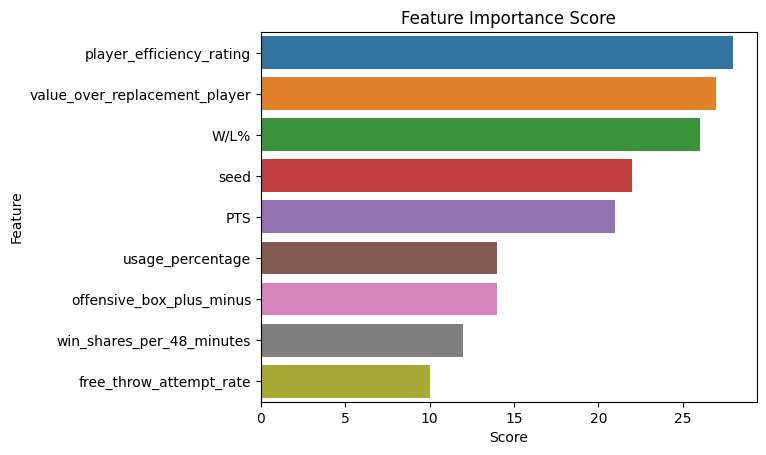

In [89]:
lgbm_model, lgbm_mvp_race_forecast = fit_forecast_model(
                                                regressor = LGBMRegressor(
                                                                    n_estimators=23,
                                                                    max_depth=4,
                                                                    learning_rate=0.15,
                                                                    num_leaves=28,
                                                                    boosting_type='goss',
                                                                    random_state = 0,
                                           ))

In [90]:
show_highlighted_df(df=lgbm_mvp_race_forecast)

,Player,Share Prediction,PTS,value_over_replacement_player,seed,W/L%,player_efficiency_rating,win_shares_per_48_minutes,offensive_box_plus_minus,usage_percentage,free_throw_attempt_rate
0,Nikola Jokic,0.519327,27.081081,9.800000,6,0.585000,32.800000,0.296000,9.200000,31.900000,0.357000
1,Giannis Antetokounmpo,0.512879,29.880597,7.400000,3,0.622000,32.100000,0.281000,7.600000,34.900000,0.615000
2,Joel Embiid,0.329178,30.573529,6.500000,4,0.622000,31.200000,0.252000,7.200000,37.200000,0.602000


### Comparision of Models

In [91]:
def comparision_models(forecast_tables,model_names):
    
    tables = []
    for name, forecast_table in zip(model_names, forecast_tables):
        player_sub = forecast_table.head(3)[['Player']]
        player_sub['Rank'] = ['1st Place','2nd Place','3rd Place']
        player_sub2 = player_sub.T.reset_index(drop=True)
        player_sub2.columns = player_sub2.iloc[1]
        player_sub2.drop(player_sub2.tail(1).index,inplace=True)

        share_sub = forecast_table.head(5)[['Share Prediction']]
        share_sub['Rank'] = ['1st Place Share','2nd Place Share','3rd Place Share']

        share_sub2 = share_sub.T.reset_index(drop=True)
        share_sub2.columns = share_sub2.iloc[1]
        share_sub2.drop(share_sub2.tail(1).index,inplace=True)

        merged_df = pd.concat([player_sub2, share_sub2], axis=1).sort_index(axis=1)
        merged_df['Model'] = name
        tables.append(merged_df)
    
    # shift column 'Name' to first position
    first_column = final_summary_table.pop('Model')
    # first_column) function
    final_summary_table.insert(0, 'Model', first_column)
    return final_summary_table

In [92]:
forecast_tables = [xgb_mvp_race_forecast, lgbm_mvp_race_forecast]
model_names = ['XGBoost', 'LightGBM']

comparision_models(forecast_tables,model_names)

1,Model,1st Place,1st Place Share,2nd Place,2nd Place Share,3rd Place,3rd Place Share
0,XGBoost,Nikola Jokic,0.679943,Giannis Antetokounmpo,0.565778,Joel Embiid,0.425511
0,LightGBM,Nikola Jokic,0.519327,Giannis Antetokounmpo,0.512879,Joel Embiid,0.329178


In [93]:
#Winner acc. to XGBoost
comparision_models(forecast_tables,model_names)['1st Place'].iloc[0]

'Nikola Jokic'

In [94]:
#Winner acc. to LightGBM
comparision_models(forecast_tables,model_names)['1st Place'].iloc[1]

'Nikola Jokic'